### Notebook 3: Gaussian Process for Surrogate Modeling

In this notebook, we will train a Gaussian Process (GP) model using an active learning scheme. At each learning iteration, this scheme enriches the training dataset with one sample such that the current GP model makes the largest expected prediction error at that sample.

> GPflow depends on both TensorFlow and TensorFlow Probability, which require very specific versions to be compatible. For example:
>
> **`!pip install gpflow tensorflow~=2.10.0 tensorflow-probability~=0.18.0`**
>
> For more details, please refer to the [official documents](https://gpflow.github.io/GPflow/2.9.1/installation.html).

### 0. Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.stats import qmc
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import gpflow
import gpflow.utilities.model_utils as util
import tensorflow as tf

### 1. Problem Setup

We select the following test function in this case study:

\begin{equation}
y(x) = 3(1-x)^2e^{(-x^2-1)}-10(0.2x-x^3)e^{-x^2}, \; x \in [-4, 1]
\end{equation}

Later on, we will train a GP model to approximate this test function. To minimize the number of employed training samples, we will use an active learning strategy to intelligiently select one new sample at each learning iteration. Details of the active learning workflow is given in a latter section. 

For now, let's first plot this function to gain some intuition.

In [2]:
def test_function(x):
    """reference function"""
    y = 3*(1-x)**2*np.exp(-x**2-1) \
            - 10*(0.2*x-x**3)*np.exp(-x**2)
    
    return y

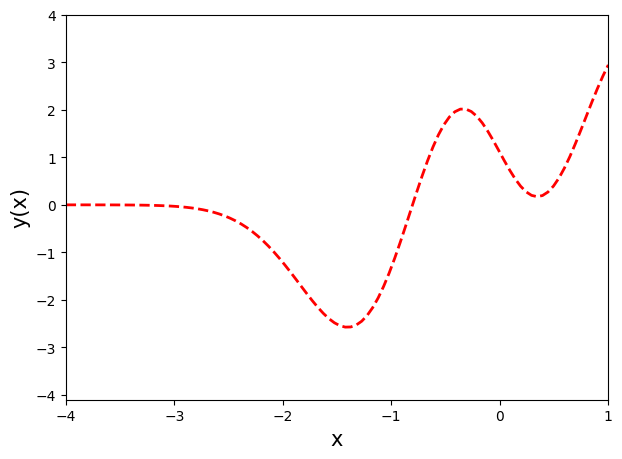

In [4]:
# Test function values
X_test = np.linspace(-4, 1, 100).reshape(-1,1)
y_test = test_function(X_test)
            
# Display test function
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test,y_test,'r--',linewidth=2,label='Test Function')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y(x)', fontsize=15)
ax.set_xlim([-4, 1]);
ax.set_ylim([-4.1, 4]);

From the figure above, we can see that the current test function describes a rather complex relationship between the input $x$ and the output $y(x)$: a flat region exists in the range [-4, -3], while multimodal responses dominate the remaining region. Since the correlation length varies significantly across the parameter space, it is challenging to construct a globally accurate GP model.

### 2. Active Learning

#### 2.1 Train an initial model

We start by training an initial GP model with 5 samples spreading evenly across the parameter space.

In [5]:
# Initial training data
X_train = np.linspace(-4, 1, 5).reshape(-1,1) 
y_train = test_function(X_train)

It is a good practice to normalize inputs before submitting it to GP model training.

In [6]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

Next, let's create a couple of helper functions to streamline the analysis.

In [11]:
def config_GP(lengthscale, X_train, y_train):
    """
    Initialize the kernel parameters.

    Args:
    -----
    lengthscale: initial length scale values for GP model.
    X_train: training input data.
    y_train: training output data.

    Returns:
    --------
    model: configured GP model using GPflow.
    """  
    
    # Set up the kernel
    kernel = gpflow.kernels.SquaredExponential(variance=np.var(y_train), lengthscales=lengthscale)

    # Set up the model
    model = gpflow.models.GPR(
        (X_train, y_train.reshape(-1, 1)),
        kernel=kernel,
        mean_function=gpflow.functions.Polynomial(0),
        noise_variance=1e-5
    )
    
    gpflow.set_trainable(model.likelihood.variance, False)
    
    return model

In [12]:
def init_kernel_params(dim, n_restarts=5):
    """
    Initialize the kernel parameters.

    Args:
    -----
    dim: input dimension. One length scale for each dimension.
    n_restarts: number of random restarts for length scale optimization.

    Returns:
    --------
    length_scales: random guesses of the length scale parameters.
    """  
    
    lb, ub = -2, 2
    lhd = qmc.LatinHypercube(d=dim, seed=42).random(n_restarts)
    length_scales = (ub-lb)*lhd + lb
    length_scales = 10**length_scales

    return length_scales

In [13]:
def fit(X_train, y_train, n_restarts=5):
    
    models = []
    log_likelihoods = []
    init_length_scales = init_kernel_params(dim=X_train.shape[1], n_restarts=n_restarts)
    
    with tf.device("CPU:0"):
    
        for i, length_scale in enumerate(init_length_scales):
    
            # Init model
            model = config_GP(length_scale, X_train, y_train)
    
            # Training
            opt = gpflow.optimizers.Scipy()
            opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))
    
            # Record keeping
            models.append(model)
            log_likelihoods.append(model.log_marginal_likelihood().numpy())
    
    # Select the model with the highest log-marginal likelihood
    best_model_index = np.argmax(log_likelihoods)
    best_model = models[best_model_index]
    
    print(f"Best model log-marginal likelihood: {log_likelihoods[best_model_index]}")

    return best_model

Let's fit an initial GP model.

In [14]:
GP = fit(X_train_scaled, y_train)

Best model log-marginal likelihood: -10.210776168793515


Then, we assess the performance of the fitted model.

In [16]:
# Assess GP prediction results
def plot_GP(GP_model, X_test, y_test, X_train, y_train, scaler, ax):
    """Plot GP prediction results"""
    
    # GP prediction
    X_test_scaled = scaler.transform(X_test)
    f_mean, f_var = GP_model.predict_f(X_test_scaled, full_cov=False)
    f_mean = f_mean.numpy().flatten()
    f_var = f_var.numpy().flatten()
    
    # Post-processing
    fig, ax = plt.subplots(figsize=(7,5))
    
    ax.plot(X_test.flatten(), y_test.flatten(), 'r--', lw=2, label='Test Function')
    ax.plot(X_train.flatten(), y_train.flatten(), 'bo', markerfacecolor='b', markersize=10, label='Training Data')  
    ax.plot(X_test.flatten(), f_mean, 'b-', linewidth=2, label='GP Prediction')
    ax.fill_between(X_test.flatten(), f_mean-1.96*np.sqrt(f_var), f_mean+1.96*np.sqrt(f_var),
                    facecolor='lavender', label='95% Credibility Interval')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(loc="upper left",prop={'size': 12})
    ax.set_xlabel('x', fontsize=15)
    ax.set_ylabel('f(x)', fontsize=15)
    ax.set_xlim([-4.2,1.2]);

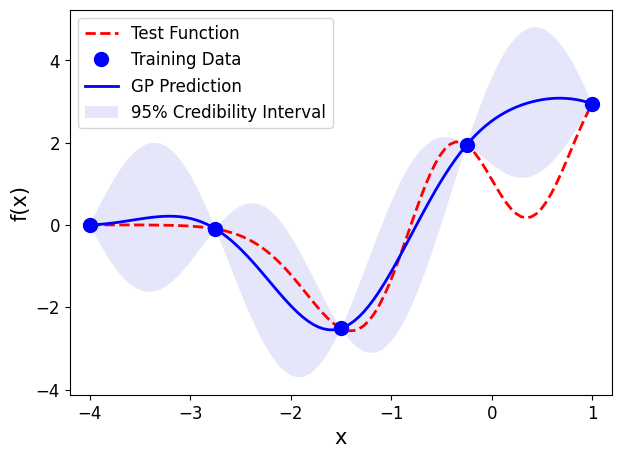

In [17]:
plot_GP(GP, X_test, y_test, X_train, y_train, scaler, ax)

As can be seen from the figure above, the GP predictions match poorly with the true test function due to an insufficient number of training samples. In the following, we will adopt the active learning strategy discussed above to gradually enrich the training dataset and refine the GP model.

#### 2.2 Acquisition function

In [18]:
def LOOCV(model):
    """Calculate leave-one-out cross-validation error
    """
    X, y = model.data
    
    # Extract kernel & mean function
    K = model.kernel(X)
    ks = util.add_likelihood_noise_cov(K, model.likelihood, X)
    m = model.mean_function(X)

    # Cholesky decomposition
    L = tf.linalg.cholesky(ks)
    
    # Calculate LOOCV error
    Q = tf.linalg.cholesky_solve(L, y-m)
    LOO = tf.reshape(Q, [-1])/tf.linalg.diag_part(tf.linalg.cholesky_solve(L, tf.eye(tf.shape(X)[0], dtype=K.dtype)))

    return LOO

In [19]:
def acquisition(model, candidate, diagnose=False):
    
    # Compute cross-validation error
    LOO = LOOCV(model).numpy().flatten()

    # Compute prediction variance
    f_mean, f_var = model.predict_f(candidate, full_cov=False)
    f_mean = f_mean.numpy().flatten()
    f_var = f_var.numpy().flatten()

    # Calculate bias
    bias = np.zeros(candidate.shape[0])
    for i in range(candidate.shape[0]):
        # Determine bias
        X, _ = model.data
        distance_sqr = np.sum((candidate[[i],:]-X.numpy())**2, axis=1)
        closest_index = np.argmin(distance_sqr.flatten())
        bias[i] = LOO[closest_index]**2

    # Calculate expected prediction error
    expected_error = bias + f_var
    target = np.max(expected_error)

    # Locate promising sample
    index = np.argmax(expected_error)

    # Select promising sample
    sample = candidate[[index],:]
    reduced_candidate = np.delete(candidate, obj=index, axis=0)

    # For diagnose purposes
    diagnostics = expected_error

    if diagnose is True:
        return target, sample, candidate, reduced_candidate, diagnostics
    
    else:
        return target, sample, candidate, reduced_candidate

#### 2.2 First iteration

Before we start iterating, we need to generate a pool of candidate samples. We will maintain this candidate pool for the subsequent iterations. At each iteration, we pick one sample from the candidate pool. This sample should yield the maximum expected prediction error value among all the candidate samples.

In [20]:
# Start active learning
iteration = 1
EPE_history = []
RMSE_history = []

# Generate candidate samples (in normalized scale)
Pool = np.random.rand(10000, 1)

Now we are ready for the first iteration.

**The following three cells can be excuted multiple times to manually control the iteration flow**. The first cell identify the sample with the maximum prediction error. The second and third cell visually summarizes the results from the current iteration and add newly identified samples to the current training dataset.

In [33]:
# 1-GP model training and predicting
GP = fit(X_train_scaled, y_train, n_restarts=5)
f_mean, _ = GP.predict_f(scaler.transform(X_test), full_cov=False)
rmse = np.sqrt(mean_squared_error(y_test.flatten(), f_mean.numpy().flatten()))

# 2-Active learning
target, sample, org_pool, Pool, EPE = acquisition(model=GP, candidate=Pool, diagnose=True)

# Record keeping
EPE_history.append(target)
RMSE_history.append(rmse)

# 3-Display iteration info
summary = 'Iteration summary:'
iter_number = 'Current iteration: {}'.format(str(iteration))

Iteration_summary = 'Iteration {}:'.format(str(iteration)) \
                    + os.linesep \
                    + 'Current max EPE is {}'.format(str(target)) \
                    + os.linesep \
                    + 'Current RMSE is {}'.format(str(rmse))

print(Iteration_summary)

Best model log-marginal likelihood: -14.807044925425103
Iteration 5:
Current max EPE is 2.5755321729264833
Current RMSE is 0.08325468011281227


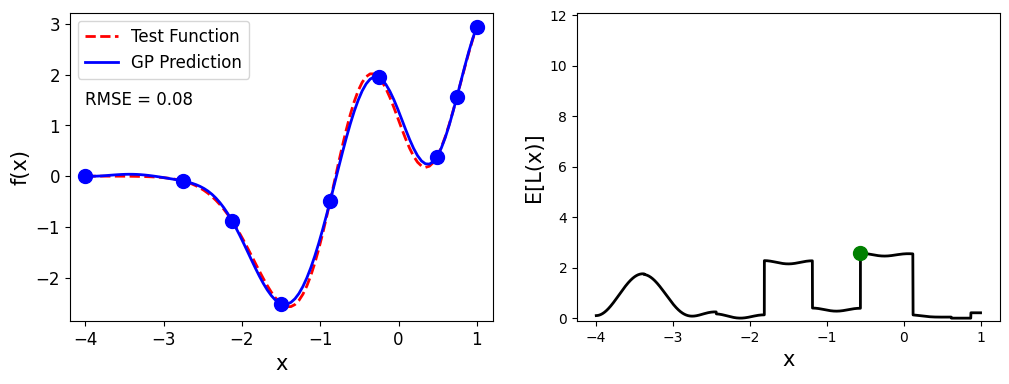

In [34]:
# 4-Iteration assessment
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(X_test, y_test,'r--', lw=2, label='Test Function')
axs[0].plot(X_train, y_train, 'bo', markerfacecolor='b', markersize=10)
axs[0].plot(X_test, f_mean.numpy(), 'b-', lw=2, label='GP Prediction')
axs[0].text(-4, 1.4, 'RMSE = {}'.format(str(np.round_(rmse, 2))), fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].legend(loc="upper left",prop={'size': 12})
axs[0].set_xlabel('x', fontsize=15)
axs[0].set_ylabel('f(x)', fontsize=15)
axs[0].set_xlim([-4.2, 1.2]);

# EPE distribution
org_pool = scaler.inverse_transform(org_pool) 
org_sample = scaler.inverse_transform(sample) 
df = pd.DataFrame(np.c_[org_pool, EPE], columns=["Candidates", "EPE-values"])
df = df.sort_values(by=['Candidates'])

axs[1].plot(df['Candidates'], df['EPE-values'], 'k-', lw=2)
axs[1].plot(org_sample, target, 'go', markersize=10)
axs[1].set_xlabel('x', fontsize=15)
axs[1].set_ylabel('E[L(x)]', fontsize=15)
axs[1].set_ylim([-0.1, 12.1]);

In [32]:
# Enrich dataset
X_train = np.vstack((X_train, org_sample))
X_train_scaled = np.vstack((X_train_scaled, sample))
y_train = np.vstack((y_train, test_function(org_sample)))
iteration += 1

After 7 iterations, we can see that the maximum $E[L(x)]$ value has dropped a lot compared with the first iteration. Correspondingly, this GP model is able to make accurate predictions across the entire parameter space. 

In practice, we monitor the change of maximum $E[L(x)]$ to define when the training can be terminated. In the current case study, we require that the maximum $E[L(x)]$ has to be smaller than 5% of the maximum $E[L(x)]$ at the first iteration.

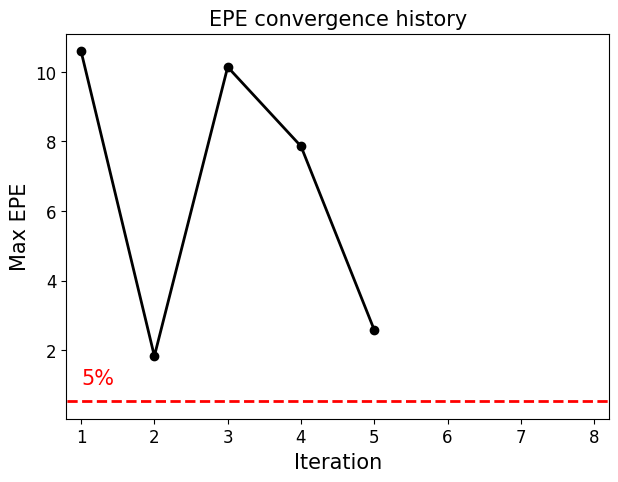

In [37]:
# EPE convergence history
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(np.arange(1, iteration+1), EPE_history, 'k-o', lw=2)
ax[0].plot([0, 8.3], [EPE_history[0]*0.05, EPE_history[0]*0.05], 'r--', lw=2)
ax[0].text(1, 1, '5%', fontsize=15, color='r')
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].set_xlabel('Iteration', fontsize=15)
ax[0].set_ylabel('Max EPE', fontsize=15)
ax[0].set_title('EPE convergence history', fontsize=15)
ax[0].set_xlim([0.8, 8.2]);

ax[1].plot(np.arange(1, iteration+1), RMSE_history, 'k-o', lw=2)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].set_xlabel('Iteration', fontsize=15)
ax[1].set_ylabel('RMSE', fontsize=15)
ax[1].set_title('RMSE history', fontsize=15)
ax[1].set_xlim([0, 1.5]);